In [ ]:
## parameterized bound box for scanning neighbors

In [36]:
import math
from collections import namedtuple
import plotly.graph_objects as go
import plotly.express as px
import numpy as np
from copy import deepcopy
from tqdm import tqdm
from tqdm.notebook import tqdm
import random

import numba as nb
# from numba import jit, vectorize, float64

In [37]:
with open('./data/tsp_51_1', 'r') as input_data_file:
    input_data = input_data_file.read()
    
lines = input_data.split('\n')
nodeCount = int(lines[0])

points = []
for i in range(1, nodeCount+1):
    line = lines[i]
    parts = line.split()
    # points.append(Point(float(parts[0]), float(parts[1])))
    points.append((float(parts[0]), float(parts[1])))
points = np.array(points)

In [45]:
@nb.jit(nopython=True)
def length_distance(single_point, all_points):
    return np.sqrt((all_points[:, 0]-single_point[0])**2 + (all_points[:, 1]-single_point[1])**2)


def euclidean_distance(point):
    return np.sqrt((point[0] - 0)**2 + (point[1] - 0)**2)

    
@nb.jit(nopython=True)
def calculate_travel(graph):
    n = len(graph)
    total_distance = 0.0

    for i in range(n - 1):
        total_distance += DISTANCE_MATRIX[graph[i], graph[i + 1]]

    # Add the distance to return to the starting point
    total_distance += DISTANCE_MATRIX[graph[-1], graph[0]]

    return total_distance


@nb.jit(nopython=True)
def calculate_travel_list(graph):
    n = len(graph)
    total_distance = np.empty(n)

    for i in range(n - 1):
        total_distance[i] = DISTANCE_MATRIX[graph[i], graph[i + 1]]

    # Add the distance to return to the starting point
    total_distance[-1] = DISTANCE_MATRIX[graph[-1], graph[0]]

    total_distance = np.argsort(-total_distance)
    
    return total_distance
    

@nb.jit(nopython=True)
def do_2opt(p1idx, p2idx, path):
    
    if p2idx > p1idx:
        slice_start = p1idx
        slice_end = p2idx
    else:
        slice_start = p2idx
        slice_end = p1idx

    new_path = np.hstack((path[:slice_start], path[slice_start:slice_end][::-1], path[slice_end:]))
    
    return new_path
    
    

def potential_gain(p1, p2, p3, p4):

    d12 = DISTANCE_MATRIX[p1][p2]
    d34 = DISTANCE_MATRIX[p3][p4] 
    d13 = DISTANCE_MATRIX[p1][p3]
    d24 = DISTANCE_MATRIX[p2][p4]
    delta = d13 + d24 - d12 - d34
    
    return delta
    
    

def pick_next_edge(p2idx, path):
    
    p1idx = p2idx-1
    p1 = path[p1idx]
    p2 = path[p2idx]
    p2_next = path[p2idx+1] if p2idx+1 < nodeCount else path[0]

    # Repeatedly do 2-opt for all the neighbors
    next_probable_edge = {}
    max_distance_delta = float('inf')
    
    # sorted_neighbor_points = np.argsort(DISTANCE_MATRIX[p1])[1:search_idx]
    sorted_neighbor_points = NEIGHBORS[p1]
    
    for neighbor_idx in sorted_neighbor_points:
       
        p4idx = np.where(path==neighbor_idx)[0][0]
        p3idx = p4idx-1
        
        potential_p3 = path[p3idx]
        potential_p4 = path[p4idx]
    
        if potential_p4 in (p1, p2, p2_next):
            continue
    
        delta = potential_gain(p1, p2, potential_p3, potential_p4)
        
        next_probable_edge[p4idx] = delta

    if not next_probable_edge.values():
        return -1, -1, 0

    max_delta_idx = min(next_probable_edge, key=lambda k: next_probable_edge[k]) # most distance decrease
    min_distance_delta = next_probable_edge[max_delta_idx]

    p3idx = max_delta_idx-1
    p4idx = max_delta_idx

    return p3idx, p4idx, min_distance_delta
    


def init_path(node_count):
    ## Keep picking the next nearest neighbor to get the path.
    
    with tqdm(total=nodeCount) as pbar:
        
        pick_next = 0
        exploring_path = np.array([], dtype=int)
        exploring_path = np.append(exploring_path, pick_next)
        
        pbar.update(1)
   
        while exploring_path.size < nodeCount:
            
            neighbor_idx = np.argsort(DISTANCE_MATRIX[pick_next])
            
            mask = np.isin(neighbor_idx, exploring_path)
            neighbor_idx = neighbor_idx[~mask]
        
            pick_next = neighbor_idx[0]
            
            exploring_path = np.append(exploring_path, pick_next)

            pbar.update(1)

    total_distance = calculate_travel(exploring_path)

    return exploring_path, total_distance


def get_neighbors(min_x, min_y, max_x, max_y, points):
    
    mask_x = np.logical_and(points[:, 0] >= min_x, points[:, 0] <= max_x)
    mask_y = np.logical_and(points[:, 1] >= min_y, points[:, 1] <= max_y)
    # points_in_bbox = points[np.logical_and(mask_x, mask_y)]
    points_idx = np.where(np.logical_and(mask_x, mask_y))[0]
    return points_idx


class TabuList:
    def __init__(self, tabu_size):
        self.tabu_size = tabu_size
        self.tabu_hash = set()
        self.tabu_queue = []

    def is_present(self, node):
        return node in self.tabu_hash

    def insert(self, node):
        if self.is_present(node):
            return
        self.tabu_hash.add(node)
        self.tabu_queue.append(node)
        if len(self.tabu_hash) > self.tabu_size:
            self.remove()
            
    def remove(self):
        top = self.tabu_queue.pop(0)
        self.tabu_hash.remove(top)

In [46]:
DISTANCE_MATRIX = np.zeros((nodeCount, nodeCount))
for i in tqdm(range(len(points))):
    DISTANCE_MATRIX[i] = length_distance(points[i], points)



  0%|          | 0/51 [00:00<?, ?it/s]

In [47]:
bbox_factor = 5

xmin, ymin = min(points, key=euclidean_distance)
xmax, ymax = max(points, key=euclidean_distance)
xsize = round((xmax-xmin)/bbox_factor)
ysize = round((ymax-ymin)/bbox_factor)

min_bbox = points-[xsize, ysize]
max_bbox = points+[xsize, ysize]

NEIGHBORS = []
for idx in tqdm(range(nodeCount)):
    min_x, min_y = min_bbox[idx]
    max_x, max_y = max_bbox[idx]

    neighbor_points = get_neighbors(min_x, min_y, max_x, max_y, points)
    NEIGHBORS.append(neighbor_points)

  0%|          | 0/51 [00:00<?, ?it/s]

In [48]:
current_path, current_distance = init_path(nodeCount)
optimal_path = deepcopy(current_path)
optimal_distance = current_distance

optimal_distance

  0%|          | 0/51 [00:00<?, ?it/s]

566.9434953326025

In [49]:
# current_path = np.array(range(nodeCount))
# random.shuffle(current_path)
# current_distance = calculate_travel(current_path)

# optimal_path = deepcopy(current_path)
# optimal_distance = current_distance

# optimal_distance

In [50]:
restarts = [
    (1000, 0.9),
    (1000, 0.9),
    (1000, 0.95),
    (100, 0.99),
    (50, 0.99),
    (20, 0.99),
    (10, 0.999)
]

In [51]:
for init_temperature, cooling_rate in restarts:
    
    iter = 0
    max_iterations = 10000
    
    final_temperature = 1e-2
    
    temperature = init_temperature
 
    # current_path = deepcopy(optimal_path)
    # current_distance = optimal_distance
    
    for iter in tqdm(range(max_iterations)):
        
        if temperature < final_temperature:
            break
            
        # for _ in range(10):
        for p2 in range(nodeCount):
            
            # pick a random point or pick points carefully        
            p2idx = np.where(current_path==p2)[0][0]
            p1idx = p2idx-1
            p1 = current_path[p1idx]
    
            p3idx, p4idx, distance_delta = pick_next_edge(p2idx, current_path)

            if p4idx == -1:
                continue
                
            p3 = current_path[p3idx]
            p4 = current_path[p4idx]
    
            new_path = do_2opt(p2idx, p4idx, current_path)
            new_distance = current_distance+distance_delta     # calculate_travel(new_path)
    
            delta = new_distance - current_distance
            acceptance_prob = np.exp(-delta/temperature)
            to_pick_prob = random.random()
            escape_local = to_pick_prob < acceptance_prob
    
            if delta < 0 or escape_local:
                
                current_path = new_path.copy()
                current_distance = new_distance
                
                if new_distance < optimal_distance:
                    optimal_path = new_path.copy()
                    optimal_distance = new_distance
                    optimal_temperature = temperature
    
        temperature *= cooling_rate
        
        if iter%10 == 0:
            print(iter, round(optimal_distance, 4), round(temperature, 4), round(cooling_rate, 5))

    #     temperature *= cooling_rate

  0%|          | 0/10000 [00:00<?, ?it/s]

0 553.1373 900.0 0.9
10 515.8496 313.8106 0.9
20 510.2255 109.419 0.9
30 510.2255 38.152 0.9
40 497.4965 13.3028 0.9
50 462.8181 4.6384 0.9
60 445.0991 1.6173 0.9
70 444.2337 0.5639 0.9
80 444.2337 0.1966 0.9
90 444.2337 0.0686 0.9
100 444.2337 0.0239 0.9


  0%|          | 0/10000 [00:00<?, ?it/s]

0 444.2337 900.0 0.9
10 444.2337 313.8106 0.9
20 444.2337 109.419 0.9
30 444.2337 38.152 0.9
40 444.2337 13.3028 0.9
50 444.2337 4.6384 0.9
60 441.6713 1.6173 0.9
70 438.5683 0.5639 0.9
80 438.5683 0.1966 0.9
90 438.5683 0.0686 0.9
100 438.5683 0.0239 0.9


  0%|          | 0/10000 [00:00<?, ?it/s]

0 438.5683 950.0 0.95
10 438.5683 568.8001 0.95
20 438.5683 340.5616 0.95
30 438.5683 203.9068 0.95
40 438.5683 122.0865 0.95
50 438.5683 73.0977 0.95
60 438.5683 43.7663 0.95
70 438.5683 26.2045 0.95
80 438.5683 15.6896 0.95
90 438.5683 9.3939 0.95
100 438.5683 5.6245 0.95
110 438.5683 3.3676 0.95
120 437.0497 2.0163 0.95
130 435.6073 1.2072 0.95
140 435.6073 0.7228 0.95
150 435.6073 0.4328 0.95
160 435.6073 0.2591 0.95
170 435.6073 0.1551 0.95
180 435.6073 0.0929 0.95
190 435.6073 0.0556 0.95
200 435.6073 0.0333 0.95
210 435.6073 0.0199 0.95
220 435.6073 0.0119 0.95


  0%|          | 0/10000 [00:00<?, ?it/s]

0 435.6073 99.0 0.99
10 435.6073 89.5338 0.99
20 435.6073 80.9728 0.99
30 435.6073 73.2303 0.99
40 435.6073 66.2282 0.99
50 435.6073 59.8956 0.99
60 435.6073 54.1685 0.99
70 435.6073 48.989 0.99
80 435.6073 44.3048 0.99
90 435.6073 40.0685 0.99
100 435.6073 36.2372 0.99
110 435.6073 32.7723 0.99
120 435.6073 29.6387 0.99
130 435.6073 26.8047 0.99
140 435.6073 24.2417 0.99
150 435.6073 21.9237 0.99
160 435.6073 19.8274 0.99
170 435.6073 17.9316 0.99
180 435.6073 16.217 0.99
190 435.6073 14.6664 0.99
200 435.6073 13.264 0.99
210 435.6073 11.9957 0.99
220 435.6073 10.8487 0.99
230 435.6073 9.8114 0.99
240 435.6073 8.8732 0.99
250 435.6073 8.0248 0.99
260 435.6073 7.2575 0.99
270 435.6073 6.5635 0.99
280 435.6073 5.9359 0.99
290 435.6073 5.3684 0.99
300 435.6073 4.855 0.99
310 435.6073 4.3908 0.99
320 435.6073 3.971 0.99
330 435.6073 3.5913 0.99
340 435.6073 3.2479 0.99
350 435.6073 2.9373 0.99
360 435.6073 2.6565 0.99
370 435.6073 2.4025 0.99
380 434.1127 2.1727 0.99
390 433.0862 1.965 0.

  0%|          | 0/10000 [00:00<?, ?it/s]

0 433.0862 49.5 0.99
10 433.0862 44.7669 0.99
20 433.0862 40.4864 0.99
30 433.0862 36.6152 0.99
40 433.0862 33.1141 0.99
50 433.0862 29.9478 0.99
60 433.0862 27.0843 0.99
70 433.0862 24.4945 0.99
80 433.0862 22.1524 0.99
90 433.0862 20.0342 0.99
100 433.0862 18.1186 0.99
110 433.0862 16.3861 0.99
120 433.0862 14.8193 0.99
130 433.0862 13.4023 0.99
140 433.0862 12.1208 0.99
150 433.0862 10.9619 0.99
160 433.0862 9.9137 0.99
170 433.0862 8.9658 0.99
180 433.0862 8.1085 0.99
190 433.0862 7.3332 0.99
200 433.0862 6.632 0.99
210 433.0862 5.9979 0.99
220 433.0862 5.4244 0.99
230 433.0862 4.9057 0.99
240 433.0862 4.4366 0.99
250 433.0862 4.0124 0.99
260 433.0862 3.6287 0.99
270 433.0862 3.2818 0.99
280 433.0862 2.968 0.99
290 433.0862 2.6842 0.99
300 433.0862 2.4275 0.99
310 433.0862 2.1954 0.99
320 433.0862 1.9855 0.99
330 433.0862 1.7956 0.99
340 433.0862 1.6239 0.99
350 433.0862 1.4687 0.99
360 433.0862 1.3282 0.99
370 433.0862 1.2012 0.99
380 433.0862 1.0864 0.99
390 433.0862 0.9825 0.99


  0%|          | 0/10000 [00:00<?, ?it/s]

0 433.0862 19.8 0.99
10 433.0862 17.9068 0.99
20 433.0862 16.1946 0.99
30 433.0862 14.6461 0.99
40 433.0862 13.2456 0.99
50 433.0862 11.9791 0.99
60 433.0862 10.8337 0.99
70 433.0862 9.7978 0.99
80 433.0862 8.861 0.99
90 433.0862 8.0137 0.99
100 433.0862 7.2474 0.99
110 433.0862 6.5545 0.99
120 433.0862 5.9277 0.99
130 433.0862 5.3609 0.99
140 433.0862 4.8483 0.99
150 433.0862 4.3847 0.99
160 433.0862 3.9655 0.99
170 433.0862 3.5863 0.99
180 433.0862 3.2434 0.99
190 433.0862 2.9333 0.99
200 433.0862 2.6528 0.99
210 433.0862 2.3991 0.99
220 433.0862 2.1697 0.99
230 433.0862 1.9623 0.99
240 433.0862 1.7746 0.99
250 433.0862 1.605 0.99
260 433.0862 1.4515 0.99
270 433.0862 1.3127 0.99
280 433.0862 1.1872 0.99
290 433.0862 1.0737 0.99
300 433.0862 0.971 0.99
310 433.0862 0.8782 0.99
320 433.0862 0.7942 0.99
330 433.0862 0.7183 0.99
340 433.0862 0.6496 0.99
350 433.0862 0.5875 0.99
360 433.0862 0.5313 0.99
370 433.0862 0.4805 0.99
380 433.0862 0.4345 0.99
390 433.0862 0.393 0.99
400 433.086

  0%|          | 0/10000 [00:00<?, ?it/s]

0 433.0862 9.99 0.999
10 433.0862 9.8905 0.999
20 433.0862 9.7921 0.999
30 433.0862 9.6946 0.999
40 433.0862 9.5981 0.999
50 433.0862 9.5025 0.999
60 433.0862 9.4079 0.999
70 433.0862 9.3143 0.999
80 433.0862 9.2216 0.999
90 433.0862 9.1298 0.999
100 433.0862 9.0389 0.999
110 433.0862 8.9489 0.999
120 433.0862 8.8598 0.999
130 433.0862 8.7716 0.999
140 433.0862 8.6843 0.999
150 433.0862 8.5978 0.999
160 433.0862 8.5122 0.999
170 433.0862 8.4275 0.999
180 433.0862 8.3436 0.999
190 433.0862 8.2605 0.999
200 433.0862 8.1783 0.999
210 433.0862 8.0969 0.999
220 433.0862 8.0163 0.999
230 433.0862 7.9365 0.999
240 433.0862 7.8575 0.999
250 433.0862 7.7792 0.999
260 433.0862 7.7018 0.999
270 433.0862 7.6251 0.999
280 433.0862 7.5492 0.999
290 433.0862 7.4741 0.999
300 433.0862 7.3997 0.999
310 433.0862 7.326 0.999
320 433.0862 7.2531 0.999
330 433.0862 7.1809 0.999
340 433.0862 7.1094 0.999
350 433.0862 7.0386 0.999
360 433.0862 6.9685 0.999
370 433.0862 6.8992 0.999
380 433.0862 6.8305 0.999


In [ ]:
output_data = '%.2f' % optimal_distance + ' ' + str(0) + '\n'
output_data += ' '.join(map(str, optimal_path))

optimal_distance

In [ ]:
with open(r'./results/tsp_100_3.txt', 'w') as file:
    # Write the Python code to the file
    file.write(output_data)

In [52]:
edge_x = []
edge_y = []

for idx in tqdm(list(optimal_path) + [list(optimal_path)[0]]):
    
    x0, y0 = points[idx]
    
    edge_x.append(x0)
    edge_y.append(y0)

  0%|          | 0/52 [00:00<?, ?it/s]

In [ ]:
edge_x = []
edge_y = []

for  x0, y0 in tqdm(points):
    
    edge_x.append(x0)
    edge_y.append(y0)

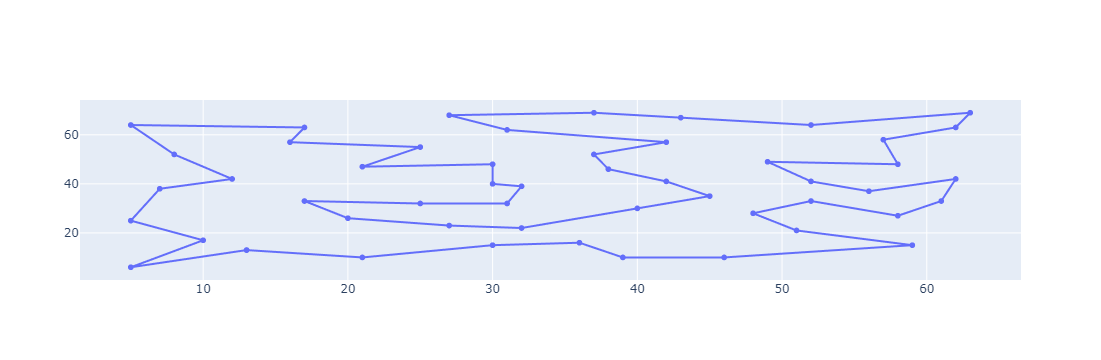

In [54]:
fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()


In [ ]:
fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()


In [ ]:
# iter = 0
# max_iterations = 10000

# init_temperature = 100
# final_temperature = 0.1 #1e-3
# cooling_rate = 0.995

# restart_counter = 0
# temperature = init_temperature
# optimal_temperature = init_temperature

# search_idx = nodeCount//5

# last_known_distance = int(optimal_distance)

# tabu_limit = nodeCount//5
# tabu_list = TabuList(tabu_limit)

# ACTIVATE = np.ones(nodeCount, dtype=int)


# search_idx, tabu_limit

# current_path = deepcopy(optimal_path)
# current_distance = optimal_distance

In [ ]:
# for iter in tqdm(range(max_iterations)):
    
#     if temperature < final_temperature:
#         break
        
#     # for _ in range(10):
#     for p2 in range(nodeCount):
    
#         if tabu_list.is_present(p2):
#             continue
        
#         # pick a random point or pick points carefully        
#         p2idx = np.where(current_path==p2)[0][0]
#         p1idx = p2idx-1
#         p1 = current_path[p1idx]

#         p3idx, p4idx, distance_delta = pick_next_edge(p2idx, current_path, search_idx)
        
#         p3 = current_path[p3idx]
#         p4 = current_path[p4idx]

#         new_path = do_2opt(p2idx, p4idx, current_path)
#         new_distance = current_distance+distance_delta     # calculate_travel(new_path)

#         delta = new_distance - current_distance
#         acceptance_prob = np.exp(-delta/temperature)
#         to_pick_prob = random.random()
#         escape_local = to_pick_prob < acceptance_prob

#         if delta < 0 or escape_local:
            
#             current_path = new_path.copy()
#             current_distance = new_distance
            
#             if new_distance < optimal_distance:
#                 optimal_path = new_path.copy()
#                 optimal_distance = new_distance
#                 optimal_temperature = temperature
                
#         if escape_local:
#             tabu_list.insert(p2)

    
#     if iter%10 == 0:
#         print(restart_counter, iter, search_idx, round(optimal_distance, 4), round(temperature, 4), round(cooling_rate, 5))
    
#     if round(optimal_distance, 1) < last_known_distance:
#         last_known_distance = round(optimal_distance, 1)
#         restart_counter = 0
#     else:
#         restart_counter += 1


#     if restart_counter >= 10:
        
#         restart_counter = 0
        
#         if cooling_rate*1.001 < 0.995:
#             cooling_rate *= 1.001
#             if optimal_temperature != init_temperature:
#                 temperature = optimal_temperature

#         # elif iter % 10 == 0 and search_idx > 10:
#         #     restart_counter = 0
#         #     search_idx = int(search_idx//1.1)
#         #     if optimal_temperature != init_temperature:
#         #         temperature = optimal_temperature
            
#         temperature *= cooling_rate

In [ ]:
edge_x = []
edge_y = []

for idx in tqdm(list(optimal_path) + [list(optimal_path)[0]]):
    
    x0, y0 = points[idx]
    
    edge_x.append(x0)
    edge_y.append(y0)

In [ ]:
fig = go.Figure(data=go.Scattergl(
    x=edge_x,
    y=edge_y,
    mode="markers+lines",
    # mode="markers"
))
fig.update_layout(height=750)
fig.show()
